In [6]:
!pip install networkx
!pip install matplotlib
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.1 MB/s eta 0:00:00a 0:00:010m
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 1.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.1 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.8 MB/s eta 0:00:00a 0:00:01


In [3]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby

## Generating graph

In [4]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

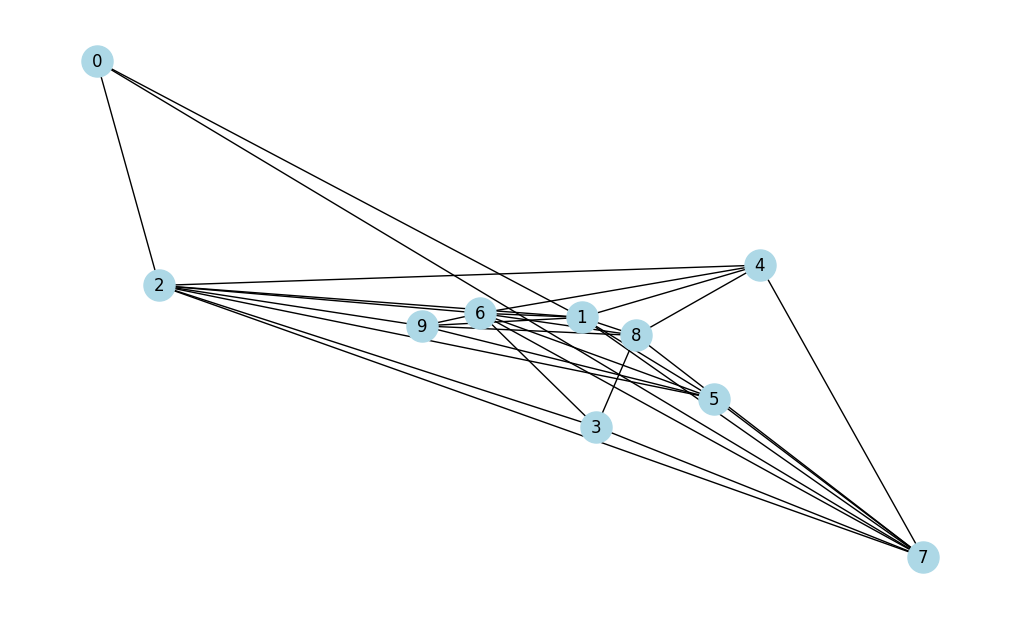

In [5]:
G = gnp_random_connected_graph(10, 0.5, False, True)

# Minimum spanning trees algorithms 

## Kruskal's algorithm

In [6]:
from networkx.algorithms import tree

In [7]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

-8.0

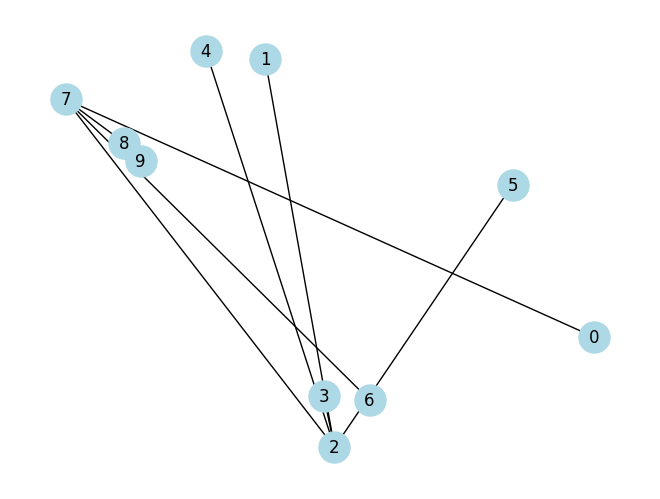

In [8]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [9]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 7), (1, 2), (2, 5), (2, 4), (2, 7), (2, 3), (6, 7), (7, 8), (8, 9)]),
 9)

In [10]:
from operator import itemgetter

def kruskal(G):
    """
    Realisation of Kruskal's algorithm to find minimal spanning 
    tree of graph G 
    """
    edges = [ ((edge[0], edge[1]), edge[2]['weight']) for edge in G.edges(data=True)]
    edges.sort(key=itemgetter(1))

    mst = nx.Graph()
    partitioning = [ {node} for node in G.nodes]

    while len(partitioning) != 1:
        
        for edge in edges:
            (u, v), weight = edge
            u_set = set()
            v_set = set()
            for partition in partitioning:
                if u in partition:
                    u_set = partition
                if v in partition:
                    v_set = partition
            if v_set != u_set:
                mst.add_edge(u, v, weight=weight)
                u_set |= v_set
                partitioning.remove(v_set)
    
    return mst

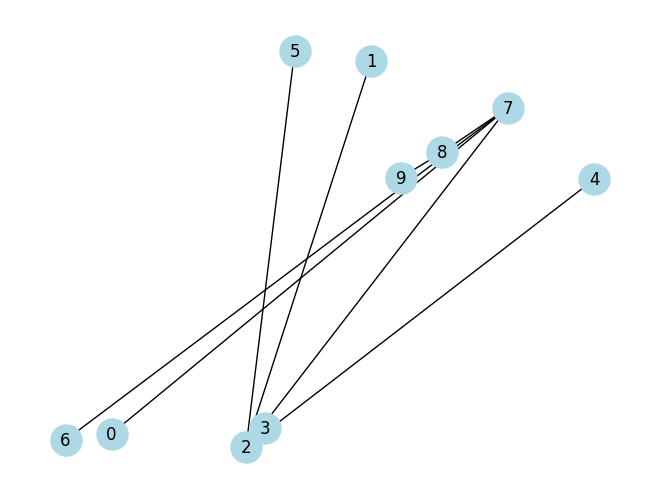

In [11]:
mstk_r = kruskal(G)

nx.draw(mstk_r, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

## Prim's algorithm

In [12]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

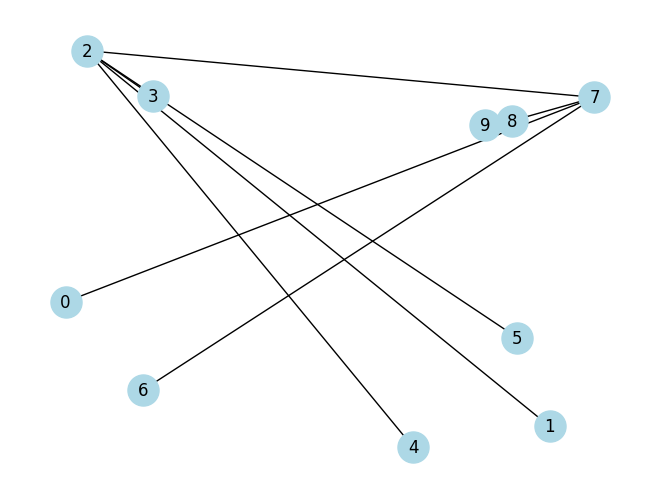

In [13]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [35]:
mstp.edges(), len(mstp.edges())
mstp.size(weight="weight")

-8.0

In [24]:
def prim_mst(G):
    """
    Find minimum spannint tree using Prim's algorithm.
    Start node is the first node in node list    
    """
    mst = nx.Graph()

    nodes = list(G.nodes)
    mst.add_node(nodes.pop(0))

    while nodes:

        minimum_edge = None
        minumum_weight = float('inf')
        
        for u in mst.nodes:
            for v in nodes:
                if G.has_edge(u, v) and G[u][v]["weight"] < minumum_weight:
                    minimum_edge = (u, v)
                    minumum_weight = G[u][v]["weight"]

        nodes.remove(minimum_edge[1])        
        mst.add_edge(*minimum_edge, weight=minumum_weight)

    return mst



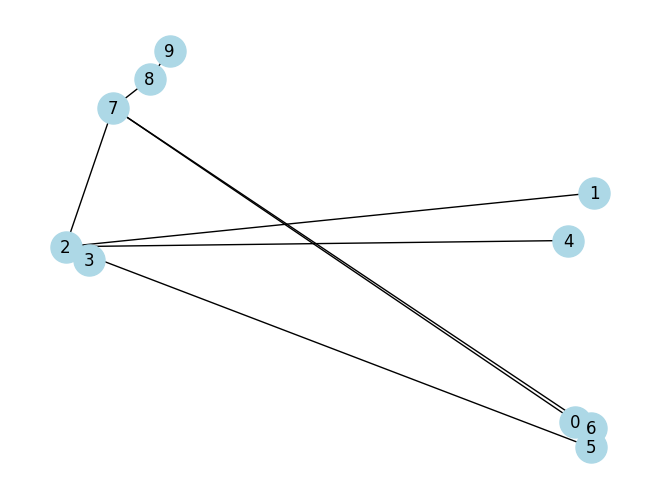

In [27]:
mstp_r = prim_mst(G)

nx.draw(mstp_r, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [36]:
mstp_r.edges(), len(mstp_r.edges())
mstp_r.size(weight="weight")

-8.0

## Testing

In [46]:
import time
from tqdm import tqdm

def test_correctness(networkx_algorithm_name: str, my_realization: callable):

    for i in range(1, 100):
        n = i*50
        for j in range(1, 20):
            G = gnp_random_connected_graph(n, 1 / j, False, False)
            mst = nx.minimum_spanning_tree(G, algorithm=networkx_algorithm_name)
            mst_r = my_realization(G)
            assert mst.size(weight="weight") == mst_r.size(weight="weight")

def test_average_time_consumption(algorithm: callable, 
                                  num_of_nodes = 100,
                                  num_of_iterations = 1000):
    time_taken = 0
    for i in tqdm(range(num_of_iterations)):
        
        # note that we should not measure time of graph creation
        G = gnp_random_connected_graph(num_of_nodes, 0.4, False)
        
        start = time.time()
        algorithm()
        end = time.time()
        
        time_taken += end - start

    return time_taken / num_of_iterations

def plot_time_size(algorithm: callable):

In [47]:
networkx_kruskal = lambda G: tree.minimum_spanning_tree(G, algorithm="kruskal") 
networkx_prim = lambda G: tree.minimum_spanning_tree(G, algorithm="prim") 

test_time_consumption()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 166.78it/s]


0.0019870603084564207

## Some useful explanations

### How to get list of edges for your algorithm

In [46]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [47]:
edges[:5]

[(0, 2), (0, 5), (0, 6), (0, 7), (0, 8)]

### To get edges with weights

In [48]:
edges = list(G.edges(data=True))

In [49]:
edges[:5]

[(0, 2, {'weight': 17}),
 (0, 5, {'weight': 19}),
 (0, 6, {'weight': 8}),
 (0, 7, {'weight': 17}),
 (0, 8, {'weight': -5})]

In [50]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [51]:
import time
from tqdm import tqdm

In [52]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

  0%|          | 0/1000 [00:00<?, ?it/s]

0.00309446382522583